In [1]:
print('starting')
import os
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import time
from scipy.stats import linregress

print('importing ancova')
from pingouin import ancova
from statsmodels.stats.multitest import fdrcorrection

print('done')

starting
importing ancova
done


In [2]:
in_file = '../../MBC/number_of_TFBS_sites_analysis/merged_data/10000-sites_data_with_features.txt'

status_col = 'revisions_ER_status_binary'

In [3]:
data = pd.read_csv(in_file, sep='\t')
data = data[((data['tumor_fraction']>=0.1) & (data['ulp_wgs_coverage']>=0.1))]


In [4]:
color_dict = {'+':'tab:blue', '-':'tab:orange'}

In [5]:
print(len(data['sample'].unique())) #191 ULP 
data[['sample',status_col]].drop_duplicates()[status_col].value_counts()

191


+    100
-     91
Name: revisions_ER_status_binary, dtype: int64

In [6]:
plot_columns = np.arange(-990,990,15)
str_plot_columns = [str(m) for m in plot_columns]

In [7]:
data.head()

,sample,patient_id,revisions_ER_status_binary,ulp_wgs_coverage,tumor_fraction,first_passing_sample,site_name,correction,central_coverage,amplitude,...,855,870,885,900,915,930,945,960,975,site_group
754,MBC_291.ctDNA_ULP,MBC_291,+,0.215313,0.3617,NaN,AHR.hg38.10000,GC_corrected,0.87586,0.20857,...,0.95774,0.97561,0.98884,0.96039,0.95066,0.94382,0.94752,0.91962,0.92803,10000-sites
755,MBC_291.ctDNA_ULP,MBC_291,+,0.215313,0.3617,NaN,AR.hg38.10000,GC_corrected,1.02241,1.38678,...,1.01067,1.04264,1.06149,1.03685,1.02966,1.06126,1.01263,1.02715,0.99868,10000-sites
756,MBC_291.ctDNA_ULP,MBC_291,+,0.215313,0.3617,NaN,ARID3A.hg38.10000,GC_corrected,0.89716,1.08908,...,1.00794,1.06200,1.04568,1.04000,1.03523,1.02836,1.00195,0.99028,0.95987,10000-sites
757,MBC_291.ctDNA_ULP,MBC_291,+,0.215313,0.3617,NaN,ARNT.hg38.10000,GC_corrected,0.87529,0.57217,...,0.92818,0.92500,0.92981,0.94586,0.95620,0.96614,0.97958,0.99225,0.96145,10000-sites
758,MBC_291.ctDNA_ULP,MBC_291,+,0.215313,0.3617,NaN,ARNTL.hg38.10000,GC_corrected,0.96816,1.98072,...,0.90246,0.87245,0.87770,0.89285,0.93366,0.94783,0.96550,0.96888,0.98909,10000-sites


In [8]:
ancova_pvals = pd.DataFrame()
for site_name in data['site_name'].unique():
    current_outputs = {'site_name':site_name}
    for feature_type in ['central_coverage','mean_coverage','amplitude']:
        current = data[data['site_name']==site_name]
        current_ancova_results = ancova(data=current, dv=feature_type, covar='tumor_fraction', between=status_col)
        status_pval = current_ancova_results.set_index('Source')['p-unc'][status_col]
        tfx_pval = current_ancova_results.set_index('Source')['p-unc']['tumor_fraction']

        #get log2 fold change
        log2fc = np.log2(current.groupby(status_col)[feature_type].mean()['+']/current.groupby(status_col)[feature_type].mean()['-'])

        current_outputs['status_pval_'+feature_type] = status_pval
        current_outputs['tfx_pval_'+feature_type] = tfx_pval
        current_outputs['log2FC_'+feature_type] = log2fc
        
    ancova_pvals = ancova_pvals.append(current_outputs, ignore_index=True)  
ancova_pvals = ancova_pvals.set_index('site_name')    

In [9]:
#fdr correct
for pval_type in ['status','tfx']:
    for feature_type in ['central_coverage','mean_coverage','amplitude']:
        significant,qval = fdrcorrection(ancova_pvals[pval_type+'_pval_'+feature_type], alpha=0.05)
        ancova_pvals[pval_type+'_adjusted-p-val_'+feature_type] = qval
        
        #ancova_pvals = ancova_pvals.drop(columns = [pval_type+'_pval_'+feature_type])


In [10]:
#reorder columns for export
ancova_pvals = ancova_pvals[['status_pval_central_coverage', 'status_adjusted-p-val_central_coverage',
              'tfx_pval_central_coverage','tfx_adjusted-p-val_central_coverage',
       'log2FC_central_coverage', 
              'status_pval_mean_coverage','status_adjusted-p-val_mean_coverage',
               'tfx_pval_mean_coverage', 'tfx_adjusted-p-val_mean_coverage', 
        'log2FC_mean_coverage',
               'status_pval_amplitude', 'status_adjusted-p-val_amplitude',
              'tfx_pval_amplitude', 'tfx_adjusted-p-val_amplitude',
              'log2FC_amplitude']]

ancova_pvals.to_csv('files/S9_ER_differential_TFBS_pvals.tsv', sep='\t')

In [11]:
feature_type = 'central_coverage'
print(len(ancova_pvals[ancova_pvals['status_adjusted-p-val_'+feature_type]<0.05][['status_adjusted-p-val_'+feature_type,'log2FC_'+feature_type]]))
ancova_pvals.sort_values(by = 'status_adjusted-p-val_'+feature_type).head(10)[['status_adjusted-p-val_'+feature_type,'log2FC_'+feature_type]]


22


,status_adjusted-p-val_central_coverage,log2FC_central_coverage
site_name,,
FOXA1.hg38.10000,4.228796e-09,-0.105428
AHR.hg38.10000,1.904315e-03,-0.055627
GATA3.hg38.10000,2.136802e-03,-0.059757
ZNF701.hg38.10000,2.136802e-03,-0.059697
GATA1.hg38.10000,1.061224e-02,-0.027768
FOXA2.hg38.10000,1.061224e-02,-0.048318
MAX.hg38.10000,1.428286e-02,-0.085115
MIXL1.hg38.10000,1.428286e-02,-0.048896
AR.hg38.10000,1.736304e-02,-0.041463


In [12]:
feature_type = 'mean_coverage'
print(len(ancova_pvals[ancova_pvals['status_adjusted-p-val_'+feature_type]<0.05][['status_adjusted-p-val_'+feature_type,'log2FC_'+feature_type]]))
ancova_pvals.sort_values(by = 'status_adjusted-p-val_'+feature_type).head(10)[['status_adjusted-p-val_'+feature_type,'log2FC_'+feature_type]]


86


,status_adjusted-p-val_mean_coverage,log2FC_mean_coverage
site_name,,
FOXA1.hg38.10000,8.969821e-10,-0.036250
NKX3-1.hg38.10000,3.143764e-08,-0.019223
ESR1.hg38.10000,2.998199e-07,-0.021606
GATA2.hg38.10000,6.165453e-07,-0.018131
HOXB13.hg38.10000,7.293111e-07,-0.015617
GATA3.hg38.10000,1.584560e-06,-0.022682
AHR.hg38.10000,3.555949e-06,-0.023475
AR.hg38.10000,4.715402e-06,-0.015323
HNF4G.hg38.10000,4.715402e-06,-0.015795


In [13]:
feature_type = 'amplitude'
print(len(ancova_pvals[ancova_pvals['status_adjusted-p-val_'+feature_type]<0.05][['status_adjusted-p-val_'+feature_type,'log2FC_'+feature_type]]))
ancova_pvals.sort_values(by = 'status_adjusted-p-val_'+feature_type).head(10)[['status_adjusted-p-val_'+feature_type,'log2FC_'+feature_type]]


4


,status_adjusted-p-val_amplitude,log2FC_amplitude
site_name,,
NFIB.hg38.10000,0.012361,-0.390012
FOSL1.hg38.10000,0.012361,0.277898
CREM.hg38.10000,0.032317,0.159165
NFE2.hg38.10000,0.032317,0.146789
MAX.hg38.10000,0.053576,0.231635
HNF4G.hg38.10000,0.068084,0.327692
GATA1.hg38.10000,0.068084,0.387638
FOXA3.hg38.10000,0.068084,0.258149
MAFK.hg38.10000,0.068084,0.120009


In [14]:
def fill_plot(ax,feature_type): 
    text_dict = {}
    for subtype in ['+','-']:
        #scatter plot the data
        current = data[(data[status_col]==subtype) & (data['site_name']==site_name)]
        x = current['tumor_fraction']
        y = current[feature_type]
        ax.scatter(x,y,  alpha = 0.3, color = color_dict[subtype])
        print(subtype,len(current))
        
        #add correlation line
        lin_reg_slope, lin_reg_intercept, pearson_r, pearson_p, lin_reg_std_err = linregress(x,y)
        fit_line = lin_reg_slope*x+lin_reg_intercept
        ax.plot(x,fit_line,color=color_dict[subtype])
        
        formatted_p = '{:0.2e}'.format(pearson_p)
        formatted_rho = str(np.round(pearson_r,2))
        current_text = 'ER'+subtype+' r='+formatted_rho+' p='+formatted_p
        text_dict[subtype] = current_text
        del(current,subtype)
        
    #get ancova result for current feature
    ER_pval = ancova_pvals.loc[site_name]['status_adjusted-p-val_'+feature_type]
    #tfx_pval = ancova_pvals.loc[site_name]['tfx_adjusted-p-val_'+feature_type]
    text = 'ANCOVA ER adj.p={:0.2e}'.format(ER_pval)#+'\n'+\
        #'TFx p={:0.2e}'.format(tfx_pval)
    ax.text(0.05,0.9, text, transform=ax.transAxes)
    
    #add correlation coefficients for the lines
    ax.text(0.05,0.83, text_dict['+'], transform=ax.transAxes)
    ax.text(0.05,0.76, text_dict['-'], transform=ax.transAxes)
    

FOXA1.hg38.10000 0.2507741451263428
+ 100
- 91
+ 100
- 91
+ 100
- 91
GATA3.hg38.10000 0.3378415107727051
+ 100
- 91
+ 100
- 91
+ 100
- 91
ESR1.hg38.10000 0.42298388481140137
+ 100
- 91
+ 100
- 91
+ 100
- 91
done


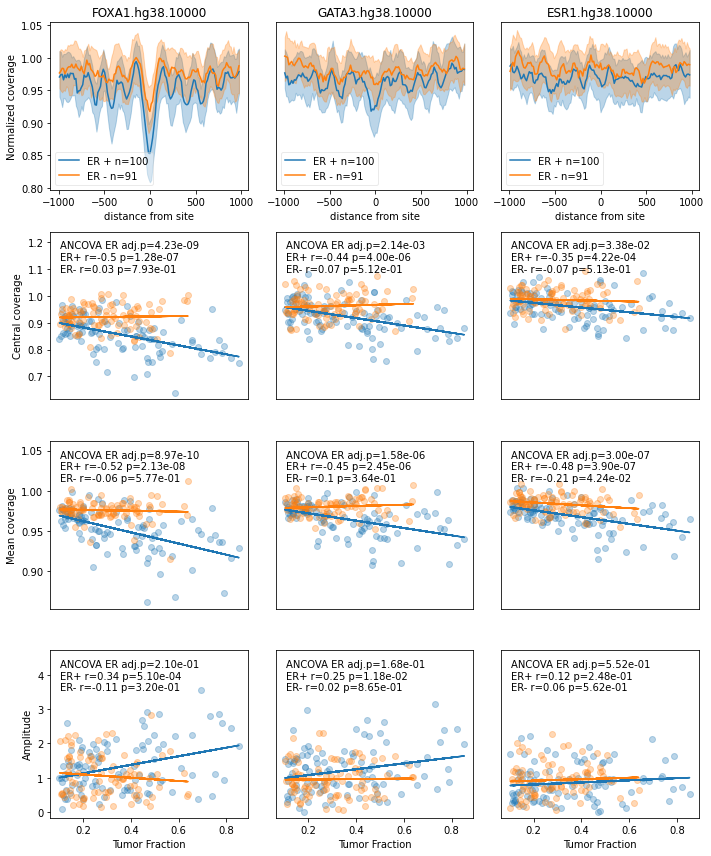

In [15]:
start_time = time.time()

fig,axes = plt.subplots(4,3,figsize=(10,12), sharey = 'row')

for i,site_name in enumerate(['FOXA1.hg38.10000','GATA3.hg38.10000', 'ESR1.hg38.10000']):
    print(site_name, time.time()-start_time)
    
    ######################
    #plot the tumor fraction correlation 
    fill_plot(axes[1,i],'central_coverage')
    axes[1,0].set_ylabel('Central coverage')
    
    fill_plot(axes[2,i],'mean_coverage')
    axes[2,0].set_ylabel('Mean coverage')

    fill_plot(axes[3,i],'amplitude')
    axes[3,0].set_ylabel('Amplitude')
    
    ######################
    #plot coverage in top row
    ax = axes[0,i]
    for subtype in ['+','-']:
        current = data[(data[status_col]==subtype) & (data['site_name']==site_name)]
        ax.plot(plot_columns, current[str_plot_columns].median(), color = color_dict[subtype], label = 'ER '+subtype+' n='+str(len(current)))
        ax.fill_between(plot_columns, np.percentile(current[str_plot_columns],25, axis = 0), np.percentile(current[str_plot_columns],75, axis = 0), color = color_dict[subtype], alpha=0.3)
    ax.set_title(site_name)
    #remove ticks on the left
    ax.tick_params(left = False)
    ax.set_xlabel('distance from site')
    ax.legend(loc='lower left', framealpha = 0.4)
    ######################

    #remove tick labels on the left of every box and the bottom of every box
    axes[1,i].tick_params(bottom = False, labelbottom = False, left = False, labelleft=False)
    axes[2,i].tick_params(bottom = False, labelbottom = False, left = False, labelleft=False)
    
    #for the last row only remove the left and add the tumor fraction label
    axes[3,i].tick_params(left = False, labelleft=False)
    axes[3,i].set_xlabel('Tumor Fraction')
    
#label the y axis in the first column
axes[0,0].tick_params(left = True, labelleft=True)
axes[1,0].tick_params(left = True, labelleft=True)
axes[2,0].tick_params(left = True, labelleft=True)
axes[3,0].tick_params(left = True, labelleft=True)

axes[0,0].set_ylabel('Normalized coverage')

#add enough space for the legends
for i in [1,2,3]:
    a,b = axes[i,0].get_ylim()
    axes[i,0].set_ylim(a,b+(b-a)*.25)


fig.tight_layout()
fig.savefig('plots/ER_differential_TFBS.pdf')
print('done')